# Objective

The objective of this notebook is to explain how to use a custom loss function using XGBoost. We will consider a regression example, but for classification the proceeding is analogue. As example will perform a regression to predict house prices for King County using XGBoost. The **data** can be found on [Kaggle](www.kaggle.com): https://www.kaggle.com/datasets/harlfoxem/housesalesprediction.

# Setup

In [1]:
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# XGBoost Regression Model

We will first train a regression model using xgboost. We will do some prior preprocessing of the data, which can be found in the notebook 01_linear_regression_xgboost. We will apply the preprocessing explored there. For further details please refer to this notebook. 

## Read the Data

In [2]:
df = pd.read_csv('data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


## Preprocessing
Here we define a function that performs the preprocessing explored in notebook 01_linear_regression_xgboost. For the purpose of this notebook we will divide the dataset in a training and validation set and omit the third test set.

In [3]:
def preprocessing(df):
    
    # used columns
    columns = ['sqft_living','grade', 'sqft_above', 'sqft_living15',
           'bathrooms','view','sqft_basement','lat','long','waterfront',
           'yr_built','bedrooms']
    # Delete entry with 33 bedrooms
    df = df[df["bedrooms"] != 33]
    
    # Convert grade, view, waterfront to type object
    df[['grade','view','waterfront']] = df[['grade','view','waterfront']].astype('object')
    
    # Create training and validation set
    X_train, X_val, y_train, y_val = train_test_split(df[columns], df['price'], test_size=0.2, shuffle=True, random_state=42)
    print(f'train data shape: X - {X_train.shape}, y - {y_train.shape}')
    print(f'validation data shape: X - {X_val.shape}, y - {y_val.shape}')
    
    # log transform the target varibale 
    y_train = np.log1p(y_train)
    y_val = np.log1p(y_val)
    
    # define categorical and numerical varibales 
    categorical = ['grade', 'view', 'waterfront']
    numerical = ['sqft_living', 'sqft_above', 'sqft_living15',
           'bathrooms','sqft_basement','lat','long',
           'yr_built','bedrooms']
    
    # one-hot encode categorical variables
    ohe = OneHotEncoder()
    X_train_cat = ohe.fit_transform(X_train[categorical]).toarray()
    X_val_cat = ohe.transform(X_val[categorical]).toarray()
    
    # define numerical columns 
    X_train_num = np.array(X_train[numerical])
    X_val_num = np.array(X_val[numerical])
    
    # concatenate numerical and categorical variables
    X_train = np.concatenate([X_train_cat, X_train_num], axis=1)
    X_val = np.concatenate([X_val_cat, X_val_num], axis=1)
    print('Shapes after one-hot encoding')
    print(f'X_train shape: {X_train.shape}, X_val shape {X_val.shape}')
    
    return X_train, X_val, y_train, y_val

In [4]:
X_train, X_val, y_train, y_val = preprocessing(df)

train data shape: X - (17289, 12), y - (17289,)
validation data shape: X - (4323, 12), y - (4323,)
Shapes after one-hot encoding
X_train shape: (17289, 28), X_val shape (4323, 28)


/home/frauke/anaconda3/envs/gen_env/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


## Modelling
Define a function for fitting and evaluating the XGBoost Model depending on different objective functions.

In [5]:
def xgb_model(X_train, y_train,Xval, y_val, 
              objective='reg:squarederror',
              learning_rate=0.3,
              min_child_weight=1,
              lambda_=1,
              gamma=0):
    
    # Initialize XGB with objective function
    parameters = {"objective": objective,
              "n_estimators": 100,
              "eta": learning_rate,
              "lambda": lambda_,
              "gamma": gamma,
              "max_depth": None,
              "min_child_weight": min_child_weight,
              "verbosity": 0}

    
    model = xgb.XGBRegressor(**parameters)
    model.fit(X_train, y_train)
    
    # generate predictions
    y_pred_train = model.predict(X_train).reshape(-1,1)
    y_pred = model.predict(X_val).reshape(-1,1)
    
    # calculate errors
    rmse_train = mean_squared_error(y_pred_train, y_train, squared=False)
    rmse_val = mean_squared_error(y_pred, y_val, squared=False)
    print(f"rmse training: {rmse_train:.3f}\t rmse validation: {rmse_val:.3f}")
    
    # plot results
    y_train = np.array(y_train).reshape(-1,1)
    y_val = np.array(y_val).reshape(-1,1)
    
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    axes[0].scatter(y_pred_train, y_train, alpha=0.5, s=5)
    axes[0].set_xlabel('predicted values')
    axes[0].set_ylabel('true values')
    axes[0].set_title(f"Training, rmse: {rmse_train:.3f}")
    axes[1].scatter(y_pred, y_val, alpha=0.5, s=5)
    axes[1].set_xlabel('predicted values')
    axes[1].set_ylabel('true values')
    axes[1].set_title(f"Validation, rmse: {rmse_val:.3f}");
    
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    frequency, bins = np.histogram(y_train, bins=50, range=[np.min(y_pred_train), np.max(y_pred_train)])
    axes[0].hist(y_train, alpha=0.5, bins=bins, density='true', label="train")
    axes[0].hist(y_pred_train, alpha=0.5, bins=bins, density='true', label="predictions")
    axes[0].legend()
    axes[1].hist(y_val, alpha=0.5, bins=bins, density='true', label="validation")
    axes[1].hist(y_pred, alpha=0.5, bins=bins, density='true', label="prediction")
    axes[1].legend();
    return y_pred_train, y_pred

Train and fit the model with root mean squared error as loss function, which is the default value.

rmse training: 0.127	 rmse validation: 0.181


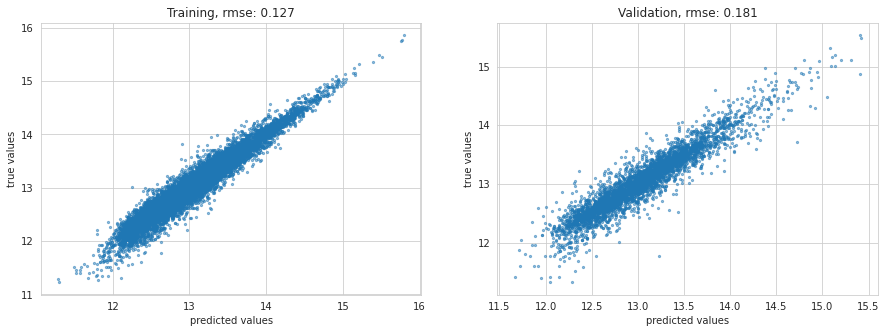

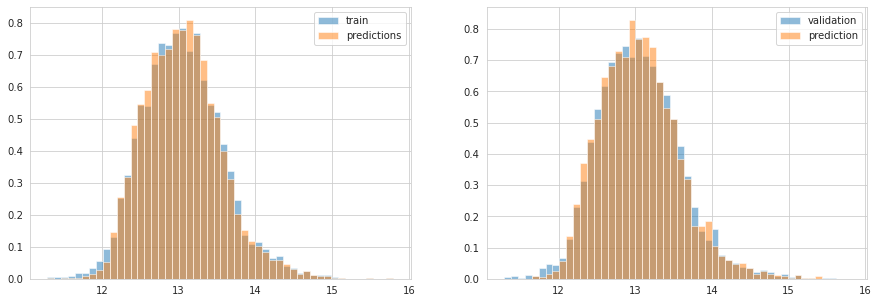

In [6]:
y_pred_train_mse, y_pred_mse = xgb_model(X_train, y_train, X_val, y_val, objective='reg:squarederror')

# Custom Loss Function

Now we will change the loss function to our custom loss function. For that first, we will have a short view on common loss functions. We will then shortly introduce the algorithm of XGBoost to understand what we need in order to implement a custom loss function. Next we will implement the above root mean squared error by ourselves and compare the result. We will then try different other loss functions and finally implement a loss function that is not so common to see how you can customize your loss.

## Common loss Functions for Regression Problems

Generally speaking in machine learning the loss function is the way to evaluate the error we make during training and is then used to reduce this error. When we train a machine learning model we aim to minimize the error, which is equivalent to minimize the loss function. This implicates that the choice of the loss function is important and needs to be specific to the task we want to solve. In general we can divide in classification and regression problems and each of them has there own loss functions. Most common examples of loss functions can e.g. be found [here](https://towardsdatascience.com/common-loss-functions-in-machine-learning-46af0ffc4d23). In this notebook we focus on regression. The most common loss function in regression problems is the mean squared error. Additionally we will consider here the mean absolute error and the huber loss. Before diving deeper into the topic let's have a look how these functions look like.

In [7]:
def losses(x, d=1):
    # mean absolute error
    mae = np.abs(x)
    
    # mean squared error
    mse = x**2
    
    # huber loss: definition: (https://en.wikipedia.org/wiki/Huber_loss)
    d = np.repeat(d, x.shape[0])
    huber = np.zeros(x.shape[0])
    less = (np.abs(x) <= d)
    more = ~less
    huber[less] = 0.5 * x[less]**2
    huber[more] = d[more]*(np.abs(x[more]) - 0.5 * d[more])
    return mae, mse, huber

In [8]:
x = np.linspace(-5,5)
mae, mse, huber_d1 = losses(x)
_, _, huber_d4 = losses(x, d=4)

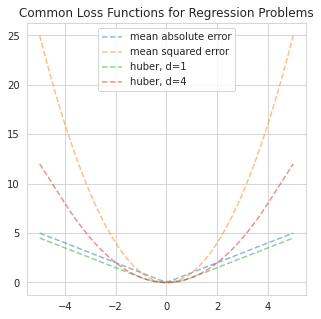

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.plot(x, mae, '--', label='mean absolute error', alpha=0.5)
ax.plot(x, mse, '--', label='mean squared error', alpha=0.5)
ax.plot(x, huber_d1, '--', label='huber, d=1', alpha=0.5)
ax.plot(x, huber_d4, '--', label='huber, d=4', alpha=0.5)
ax.set_title("Common Loss Functions for Regression Problems")
ax.legend();
ax.legend();
fig.savefig('common_loss_regresion.jpg')

### XGBoost Algorithm and Loss Functions

We will not explain the algorithm of XGBoost here in detail, however we need a short overview in order to understand, what we need in order to define a custom loss function. Let's assume we have a regression problem, with input $X$ and labels $y$. The algorithm of XGBoost is a graident-boosting method, where the next tree is predicting the residual error. In the beginning (time step $t_0$) we have a prediction $\hat{y}_{t_0}$, which by default is $0.5$. The residuals $\hat{y}_{t_0} - y$ are calculated and a tree is fitted to these residuals. That is in contrast to e.g. a Random Forest the each tree does not directly try to predict $y$, but the residual $y - \hat{y}_{t_0}$.  The new $\hat{y}_{t_1}$ is then $\hat{y}_{t_0} + R_{t_1}(X)$, where $R_{t_1}(X)$ are the predicted residuals. The next tree again predicts the residuals and we get $\hat{y}_{t_2} = \hat{y}_{t_0} + R_{t_1}(X) + R_{t_2}(X) = \hat{y}_{t_1} + R_{t_2}(X)$ and so on. A very nice and detailed explanation of XGBoost for regression with a concrete example can be found in this video series from [StatQuest](https://youtu.be/OtD8wVaFm6E).

This was just a very short intro into the algorithm of XGBoost, however important to understand what we need in order to define a custom loss function. The loss function is depending on $y$ and $\hat{y}_t$, let's denote it as $l(y, \hat{y}_t)$. With the above exlained approach of XGBoost we can rewrite $\hat{y}_t$ to $\hat{y}_{t-1} + R_t(x)$. The idea is then to approximate the loss function by a [Taylor's expantion](https://en.wikipedia.org/wiki/Taylor_series) up to the second derivative. 
    
$l(y, \hat{y}) = l(y, a + \Delta \hat{y})$

$l(y, \hat{y}) = l(a) + l'(a)(\hat{y} - a) + 1/2 \cdot l''(a)(\hat{y} - a)^2$, with $a = \hat{y}_{t-1}$, $\Delta \hat{y} = R_t(X)$

$ l(y, \hat{y}_{t-1} + R_t(X)) = l(y, \hat{y}_{t-1}) + l'(\hat{y}_{t-1}) R_t(X) + 1/2 \cdot l''(\hat{y}_{t-1})R_t(X)^2$

This is then the function that is minimized. This approach explains that in order to define a custom loss function for XGBoost, we need the first and the second derivative - or more generally speaking the gradient and the hessian matrix. A detailed explanation of XGBoost and how the loss is calculated can be found in the post [De-Mystifying XGBoost](https://towardsdatascience.com/de-mystifying-xgboost-part-i-f37c5e64ec8e). 

## Custom Loss Functions in XGBoost

### Mean Squared Error

We will define a custom loss function for the mean squared error and compare the results to the above results with the already implemented mean squared error. As we just learned in order to do that we need the gradient and the hessian matrix. For the mean squared error these functions are not so difficult to find.

We define a function ```mse_loss```, where the gradient and hessian matrix are calculated. This function is then given to the XGBoost training, via the ```'objective'``` parameter.

In [10]:
def mse_loss(y_pred, y_val):
    # l(y_val, y_pred) = (y_val-y_pred)**2
    grad = 2*(y_val-y_pred)
    hess = np.repeat(2,y_val.shape[0])
    return grad, hess

rmse training: 0.124	 rmse validation: 0.180


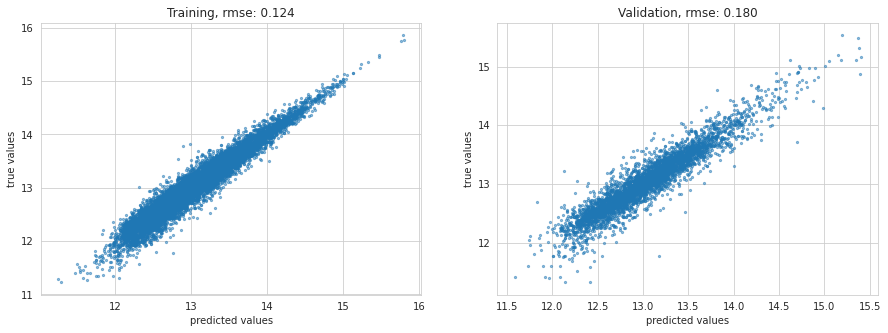

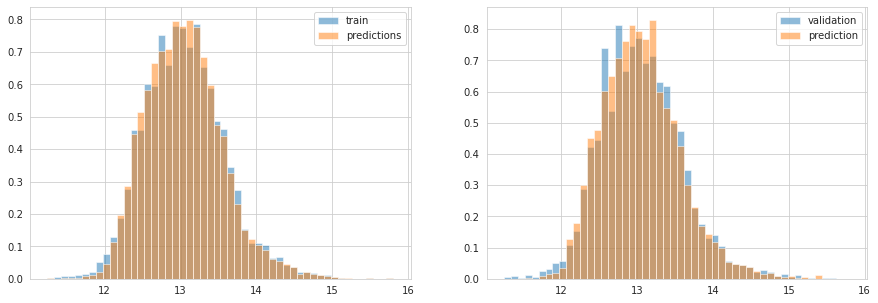

In [11]:
y_pred_train_mse_c, y_pred_mse_c = xgb_model(X_train, y_train, X_val, y_val, objective=mse_loss)

We can see that the results differ slightly, probably due to numerical issues like rounding etc., but generally we could reproduce the result from above. Now let's invesigate some more loss functions.

### Mean Absolute Error

Now, knowing what we need in order to define a loss function in XGBoost, we can see the problem with the mean absolute error (MAE). The MAE is not differentiable at all points and additionally the second derivative is equal to zero. We can implement the MAE loss anyway, just ignoring this fact. 

In [12]:
def mae_loss(y_pred, y_val):
    # f(y_val) = abs(y_val-y_pred)
    grad = np.sign(y_val-y_pred)*np.repeat(1,y_val.shape[0])
    hess = np.repeat(0,y_val.shape[0])
    return grad, hess

rmse training: 12.557	 rmse validation: 12.565


/home/frauke/anaconda3/envs/gen_env/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


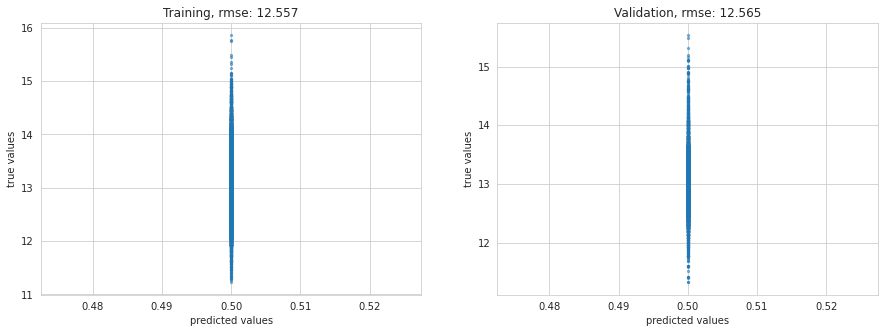

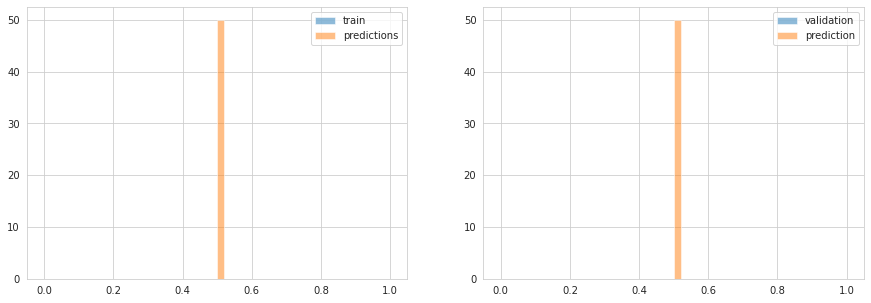

In [13]:
y_pred_train_mae, y_pred_mae = xgb_model(X_train, y_train, X_val, y_val, objective=mae_loss)

Implementing MAE shows that the algorithm is not learning at all. We can change the model parameters as we want, predictions will always remain the initial predictions 0.5. If you set ```verbose: 2``` in the training you can see, that no new nodes are created. In XGBoost the tree is only further splitted if the loss of the child node is lower than the hyperparamter $\gamma$. $\gamma$ or ```min_child_weight``` is a value in the interval $[0, \infty]$, by default set to $1$. As we can read in the [documentation](https://xgboost.readthedocs.io/en/stable/tutorials/model.html) of XGBoost, the loss of each node is proportional to the gradient squared divided by the hessian matrix plus a regularization paramter $\lambda$. In the above case the gradient is constant and the hessian is $0$ for all points. That means the loss of each new node remains the same and therefore there cannot be an improvement. The alternative supported implementation of the MAE is the [Pseudo-Huber-Loss](https://en.wikipedia.org/wiki/Huber_loss#Pseudo-Huber_loss_function) using [reg:pseudohubererror](https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters). 

### Pseudo-Huber-Loss

rmse training: 517.204	 rmse validation: 517.197


/home/frauke/anaconda3/envs/gen_env/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


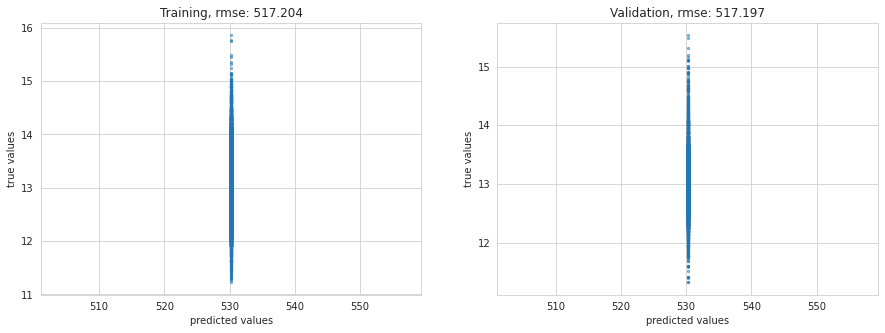

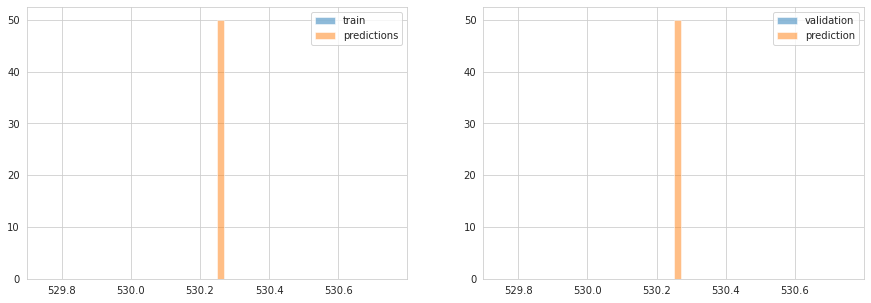

In [14]:
y_pred_train_phl, y_pred_phl = xgb_model(X_train, y_train, X_val, y_val, 
                                          objective='reg:pseudohubererror', 
                                          learning_rate=0.3)

To achieve better results, we change the learning rate.

rmse training: 0.288	 rmse validation: 0.292


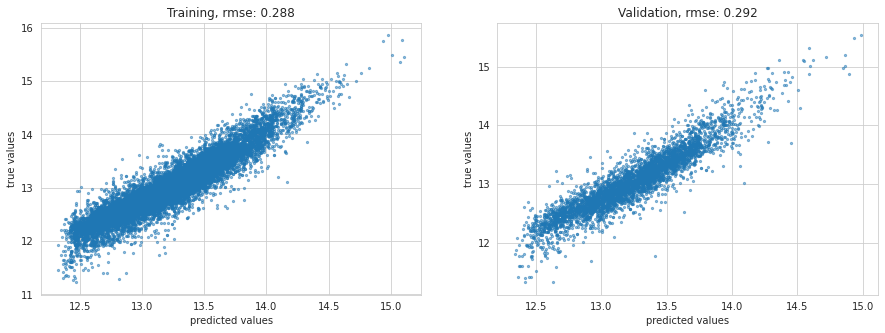

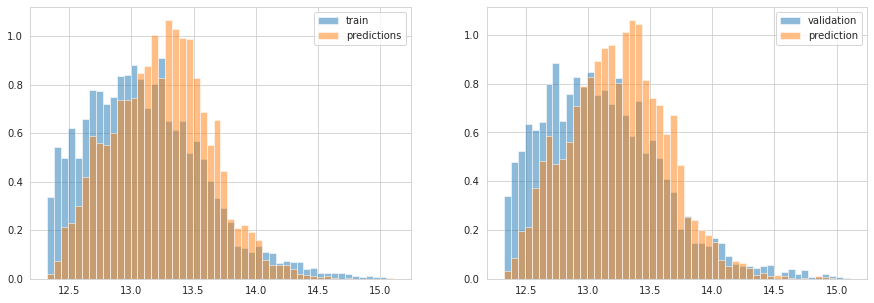

In [15]:
y_pred_train_psl, y_pred_phl = xgb_model(X_train, y_train, X_val, y_val, 
                                          objective='reg:pseudohubererror', 
                                          learning_rate=0.0121)

We can also implement this by ourselfs.

In [16]:
def pseudo_huber_loss(y_pred, y_val):
    d = (y_val-y_pred)
    delta = 1  
    scale = 1 + (d / delta) ** 2
    scale_sqrt = np.sqrt(scale)
    grad = d / scale_sqrt 
    hess = (1 / scale) / scale_sqrt
    return grad, hess

rmse training: 0.288	 rmse validation: 0.292


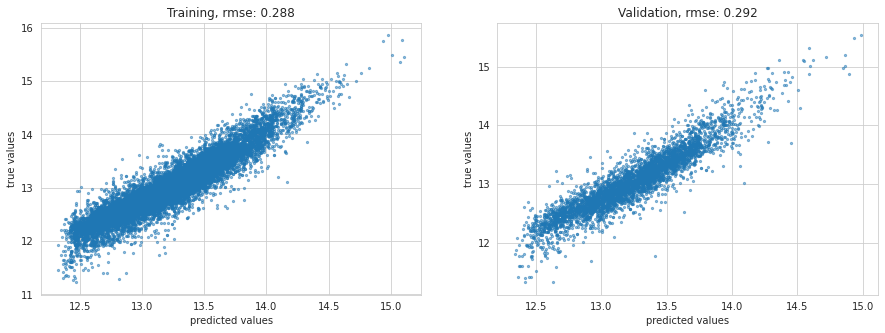

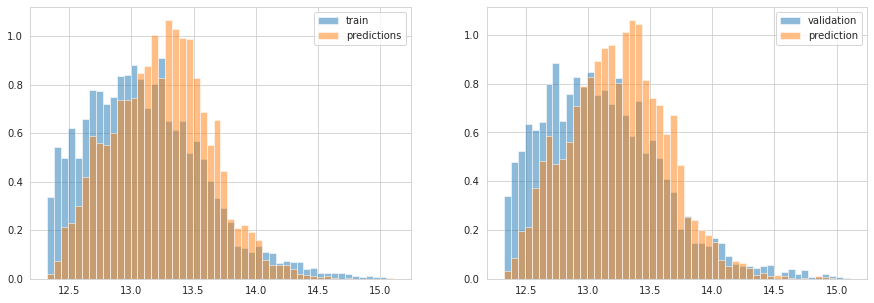

In [17]:
y_pred_train_phl_c, y_pred_phl_c = xgb_model(X_train, y_train, X_val, y_val, 
                                              objective=pseudo_huber_loss,
                                              learning_rate=0.0121)

### Example of Custom Loss Function

Now we have seen some common loss functions for regression problems. For our example the MSE works very well. However, sometimes you want to customize your loss function in order to focus on certain values. E.g. maybe your target distribution has some extreme values. Or if you are considering a classification problem you are encountering class imbalances. These are typical problems that may appear in Machine Learning. There is no recipe how to deal with such problems, but one posibility is to adjust the loss function in a form that it penalizes more for these outliers or the minority class.

You can use the same method as above to define any loss function you like. As said in the example above such a customized loss function is not necessary as the standard loss functions work well. However, we will define some customized loss  functions to show how it works.

In [18]:
def more_losses(x, d=1):
    # mean absolute error
    mae = np.abs(x)
    
    # mean squared error
    mse = x**2
    
    # huber loss: definition: (https://en.wikipedia.org/wiki/Huber_loss)
    d = np.repeat(d, x.shape[0])
    huber = np.zeros(x.shape[0])
    less = (np.abs(x) <= d)
    more = ~less
    huber[less] = 0.5 * x[less]**2
    huber[more] = d[more]*(np.abs(x[more]) - 0.5 * d[more])
    
    # cubic loss
    cubic = x**4
    
    # assymetric loss
    assym = np.where(x < 0, (x**2)*50.0, x**2) 

    return mae, mse, huber, cubic, assym

In [19]:
x = np.linspace(-5,5)
mae, mse, huber_d1, cubic, assym = more_losses(x)
_, _, huber_d4, _, _ = more_losses(x, d=4)

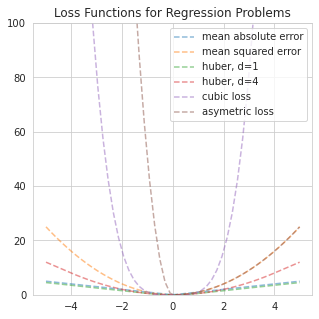

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.plot(x, mae, '--', label='mean absolute error', alpha=0.5)
ax.plot(x, mse, '--', label='mean squared error', alpha=0.5)
ax.plot(x, huber_d1, '--', label='huber, d=1', alpha=0.5)
ax.plot(x, huber_d4, '--', label='huber, d=4', alpha=0.5)
ax.plot(x, cubic, '--', label='cubic loss', alpha=0.5)
ax.plot(x, assym, '--', label='asymetric loss', alpha=0.5)
ax.set_title("Loss Functions for Regression Problems")
ax.set_ylim([0,100])
ax.legend();
ax.legend();
fig.savefig('more_losses_regresion.jpg')

Here we plotted two more functions, the cubic function and a loss function that is basically the mean squared error, when the residual is positive and 50 times the Mean squared error, when it is negative. This puts more weights on the negative residuals.

In [21]:
def cubic(y_pred, y_val):
    # f(y_val) = (y_val-y_pred)**4
    grad = 4*(y_val - y_pred)**3
    hess = 12*(y_val - y_pred)**2
    return grad, hess

rmse training: 0.140	 rmse validation: 0.180


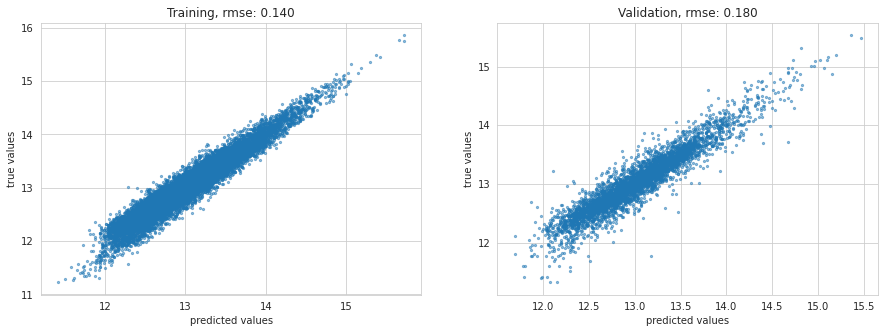

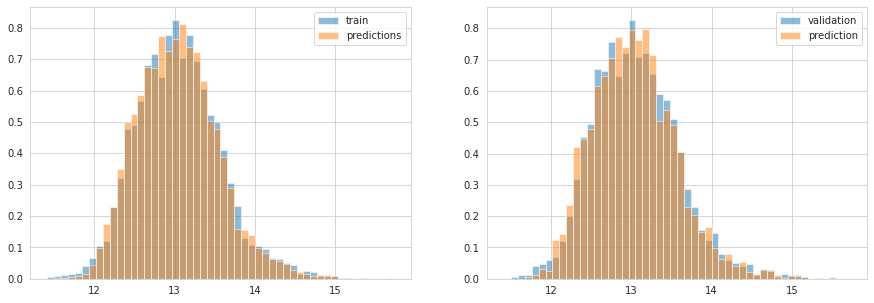

In [22]:
y_pred_train_cub, y_pred_cub = xgb_model(X_train, y_train, X_val, y_val, objective=cubic)

In [23]:
def assym_loss(y_val, y_pred):
    grad = np.where((y_val - y_pred)<0, -2*50.0*(y_val - y_pred), -2*(y_val - y_pred))
    hess = np.where((y_val - y_pred)<0, 2*50.0, 2.0)
    return grad, hess

rmse training: 0.238	 rmse validation: 0.284


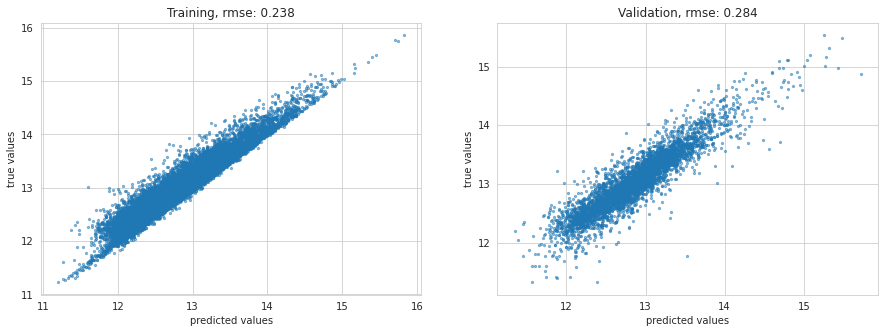

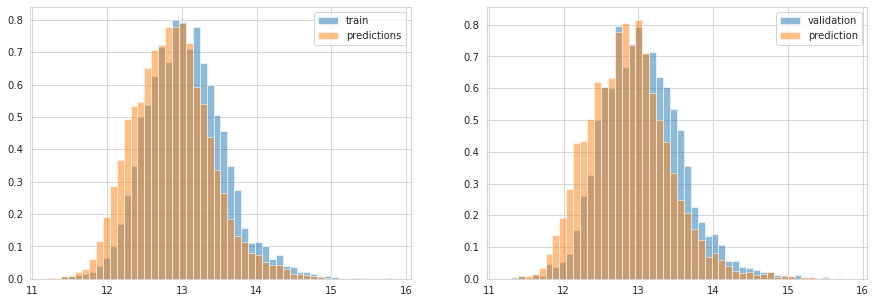

In [24]:
y_pred_train_asy, y_pred_asy = xgb_model(X_train, y_train, X_val, y_val, objective=assym_loss)

We can see how the different loss function influence the results. In the latter (assym_loss) the distribution of the prediction is skewed to the left. This is because the loss function penalizes these losses more. In the above case such a loss function is not reasonable, however, when you are dealing with skewed training distributions this might be useful.

# Further Reading

* An example of the implemantation of the Squared Log Error (SLR) can be found here: https://xgboost.readthedocs.io/en/stable/tutorials/custom_metric_obj.html
* Post about custom loss in XGBoost https://towardsdatascience.com/custom-loss-functions-for-gradient-boosting-f79c1b40466d
* List of supported loss functions for XGBoost: https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters
* Question and answer about MAE implementation in XGB https://stackoverflow.com/questions/45006341/xgboost-how-to-use-mae-as-objective-function
